In [1]:
from ..model.layers import Hough_Transform, AccumulationSpace  #, plot_hist
from data.labels import load_video, get_segmentation
from main import shrink_h
import cv2 as cv
import numpy as np
import time
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns


ImportError: attempted relative import with no known parent package

### Parameters
Setting parameters for all experiments below:


In [2]:
# shape of facet plane
h_plane = 7
w_plane = 7
# shape of Hough Space (not relevant for this notebook as we are only focusing on the facet planes)
HS_shape = (200, 200)

### Loading image
loading a simple example image without noise. 

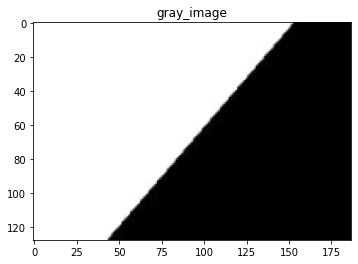

In [3]:
root = "data/"
#root = "C:/Users/HP/Documents/Uni/10.Semester/Pallet_detection/data/pallet/"
filename = "diag_edge.jpg"
path = os.path.join(root, filename)
img = cv.imread(path)

rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(rgb_img, cv.COLOR_RGB2GRAY)
gray = shrink_h(gray, 128)
gray = np.array(gray).astype(int)

plt.imshow(gray, cmap="gray")
plt.title("gray_image")
plt.show()


### Estimating Noise during HT
The estimated noise is close to 0 as it should be.

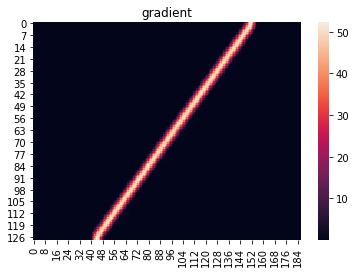

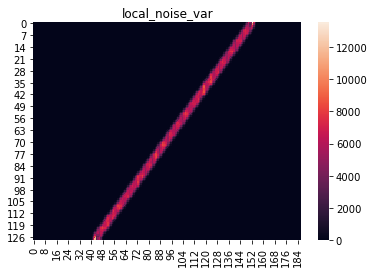

Noise Variance = 7.222325759540544e-05


In [4]:
HT = Hough_Transform(input_dim=gray.shape, output_dim=HS_shape, h_plane=h_plane, w_plane=w_plane)

_ = HT.approximate_plane(gray, visualize=True)


### Adding artificial noise
#### First approach (dropped)
Note that even thoigh the noise we add has a standard deviation of $\sigma = 10$, the variance of the noise in the image is not 100:

The image is clipped to the range of (0, 255). Almost all pixels in our example are either 0 or 255, hence about half the noise is not applied to the image as it is clipped of. 

So the applied noise that is not clipped of is distributed like a half gaussian. And thus the mean is  
$$mean_1 = \sigma_{gaussian} * \sqrt{2/\pi} \approx 8 $$
All other noise is clipped of and thus 0
$$mean_2 = 0$$
So we get a total mean of 
$$mean = \frac{\sigma_{gaussian}}{\sqrt{2 \pi}}$$

Due to the complex analysis, I dropped this approach and decided to try a simpler one.
#### Second approach
Analizing the variance of the two step random experiment described above is quite hard so I decided to change the intensities of the original image from (0,255) to (50, 205) so that no (relevant amount of) noise is clipped off at 0 or 255 and the applied noise is actually normal distributed.

With this setting the estimator estimates a noise variance of about 100, which is correct. 
Note, that it is over estimating the noise a bit. I'll write about that below. 

 old range of image intensities: (0, 255)
 new range of image intensities: (50.0, 205.0)


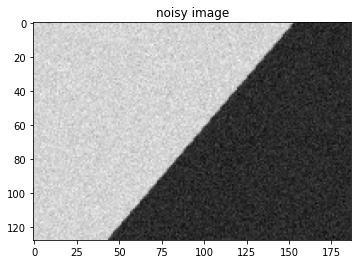

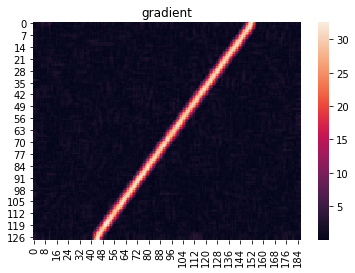

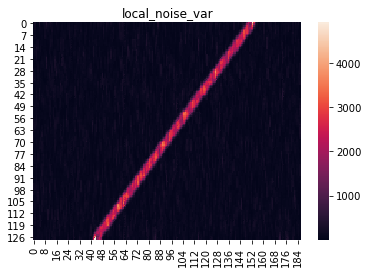

Noise Variance = 105.83745970402124


In [21]:
# Shifting image intensity range:

print(f" old range of image intensities: ({np.min(gray)}, {np.max(gray)})")
gray_shifted = gray / 255 * 155 + 50
print(f" new range of image intensities: ({np.min(gray_shifted)}, {np.max(gray_shifted)})")

# Adding Noise:

sigma = 10
noise = np.random.normal(loc=0, scale=sigma, size=gray.shape)
gray_noisy = np.clip(gray_shifted + noise, a_min=0, a_max=255)

#ax = sns.heatmap(gray_noisy, linewidth=0)
plt.imshow(gray_noisy, cmap="gray")
plt.title("noisy image")
plt.show()

noise_var = HT.approximate_plane(gray_noisy, visualize=True)[-1]

### Hallway Image
Now we test the Noise estimation on the Hallway Image

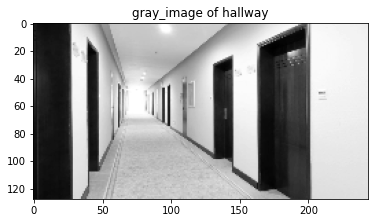

In [20]:
filename = "hallway.jpg"
path_hall = os.path.join(root, filename)
img_hall = cv.imread(path_hall)

rgb_img_hall = cv.cvtColor(img_hall, cv.COLOR_BGR2RGB)
gray_hall = cv.cvtColor(rgb_img_hall, cv.COLOR_RGB2GRAY)
gray_hall = shrink_h(gray_hall, 128)

#ax = sns.heatmap(gray_hall, linewidth=0)
plt.imshow(gray_hall, cmap="gray")
plt.title("gray_image of hallway")
plt.show()

And we see that we have an image noise ~1 which sounds reasonable as the image looks very smooth

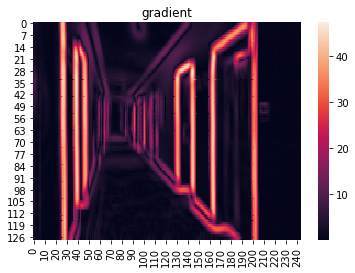

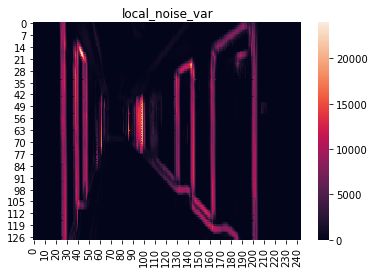

Noise Variance = 1.013680333997241


In [7]:
HT_hall = Hough_Transform(input_dim=gray_hall.shape, output_dim=HS_shape, h_plane=h_plane, w_plane=w_plane)
_ = HT_hall.approximate_plane(gray_hall, visualize=True)

### How does the estimator behave in relation to the applied noise?
testing the estimated variance of a blank image which I artificially added noise of varying variances.

The estimator is estimating the noise pretty good. Sightly over estimating but only very little.

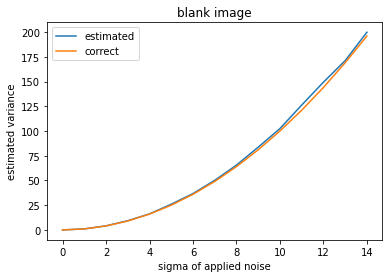

In [8]:
def parameter_study_sigma(image, title = "parameter study", h_plane=5, w_plane=5):
    sigma_range = np.arange(0, 15)
    var_applied = sigma_range**2
    var_estimated = np.zeros(sigma_range.shape)
    HT = Hough_Transform(input_dim=image.shape, output_dim=HS_shape, h_plane=h_plane, w_plane=w_plane)
    for i, sigma in enumerate(sigma_range):
        noise = np.random.normal(loc=0, scale=sigma, size=image.shape)
        noisy_image = np.clip(image + noise, a_min=0, a_max=255)
        var_estimated[i] = HT.approximate_plane(noisy_image, visualize=False)[-1]

    plt.plot(sigma_range, var_estimated, label="estimated")
    plt.plot(sigma_range, var_applied, label="applied")
    plt.xlabel("sigma of applied noise")
    plt.ylabel("estimated variance")
    plt.title(title)
    plt.legend()
    plt.show()

blank_image = np.full(gray.shape, 122)

parameter_study_sigma(blank_image, "blank image", h_plane=h_plane, w_plane=w_plane)

Testing the same plot for the shifted image with the edge. again estimated noise fits the added noise well, but is slightly over estimating, as noise increases:

I have an explaination, where this is over estimation is coming from:

To get the total noise variance I average the local noise variance, weighted by the respective inverted gradient. As long as the image has no or only little noise, the inverted gradient for the edges is very small compared to the inverted gradients of flat areas. The weights are normalized, so that the weights of edges are very small as their inverted gradients are very small while those for flat areas are very large. So for small noise, the wrong noise estimations from the lines is weighted very little.

The higher the noise, the higher the gradient at flat areas of the image, while the gradient for edges stays constant or even decreases due to noise. So as noise increases, the weights for flat areas decrease and thus weights for edges increase. So with increasing noise, the wrong noise estimations are weighted more, causing an over estimation for the overall noise level.

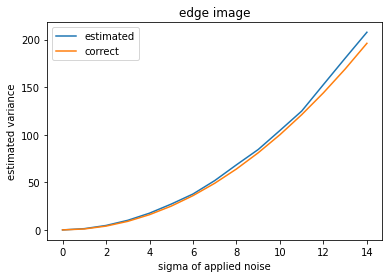

In [9]:
parameter_study_sigma(gray_shifted, "edge image", h_plane=h_plane, w_plane=w_plane)

And again for the hallway image. This time the noise is strongly over estimated when adding noise. For my interpretation see above.

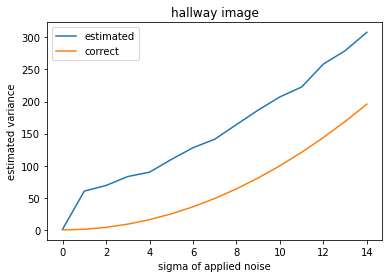

In [10]:
parameter_study_sigma(gray_hall, "hallway image", h_plane=h_plane, w_plane=w_plane)

### investigating influence of the size of the facet plane
Maybe the noise of the Hallway Image is only estimated so badly because the size of the facet plane is choosen badly.

To make sure this is not the case I did a parameter study for the size of the facet plane.

And it turend out that all sizes I tried for the facet plane are over estimating the noise. So the choice of the facet plane's size is not the reason for the over estimation 

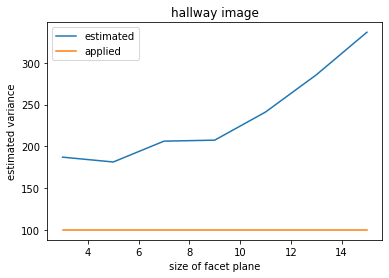

In [23]:
def parameter_study_facet_size(image, title = "parameter study", sigma=10):
    facet_size_range = np.arange(3, 17, 2) # 3, 5, ..., 15
    var_estimated = np.zeros(facet_size_range.shape)
    var_applied = np.full(facet_size_range.shape, sigma**2)
    for i, facet_size in enumerate(facet_size_range):
        HT = Hough_Transform(input_dim=image.shape, output_dim=HS_shape, h_plane=facet_size, w_plane=facet_size)
        noise = np.random.normal(loc=0, scale=sigma, size=image.shape)
        noisy_image = np.clip(image + noise, a_min=0, a_max=255)
        var_estimated[i] = HT.approximate_plane(noisy_image, visualize=False)[-1]

    plt.plot(facet_size_range, var_estimated, label="estimated")
    plt.plot(facet_size_range, var_applied, label="applied")
    plt.xlabel("size of facet plane")
    plt.ylabel("estimated variance")
    plt.title(title)
    plt.legend()
    plt.show()

parameter_study_facet_size(gray_hall, "hallway image")